## <font color=green> Time Series Forecasting usando Decision Tree e Gradient Boosting

In [1]:
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
%config Completer.use_jedi = False

- Carregando os dados de concentração de CO2 de 1958 a 2001

In [3]:
data = sm.datasets.co2.load_pandas().data
data.head()

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


- Visualizando o dado

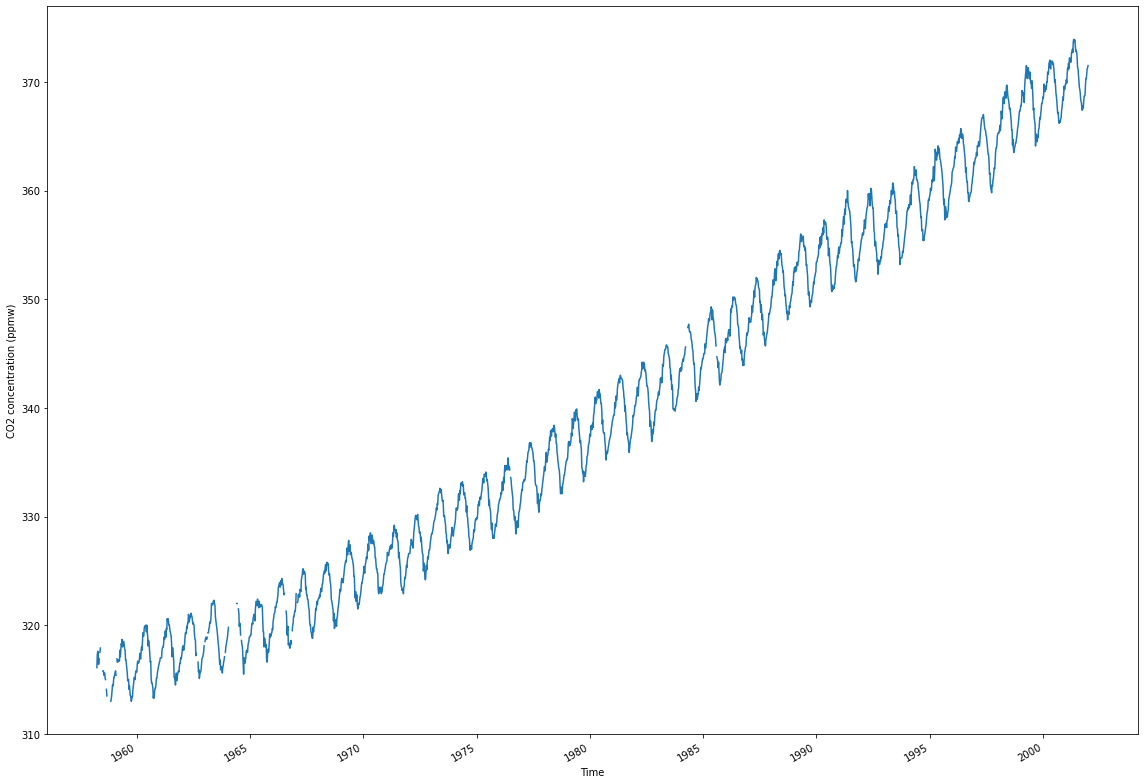

In [4]:
fig, ax = plt.subplots(figsize=(16, 11))
ax.plot(data['co2'])
ax.set_xlabel('Time')
ax.set_ylabel('CO2 concentration (ppmw)')
fig.autofmt_xdate()
plt.tight_layout()

In [5]:
data.isnull().sum()

co2    59
dtype: int64

- É possível notar que há uma sazonalidade anual, devido as estações do ano. Há também uma tendência positiva. É possível notar também que há dados faltantes.

- Vamos então tratar os dados faltantes usando interpolação. O método faz uma simples interpolação linear entre dois pontos conhecidos para preencher os valores faltantes.

In [6]:
data = data.interpolate()
data.isnull().sum()

co2    0
dtype: int64

- Visualizando o dataset com interpolação

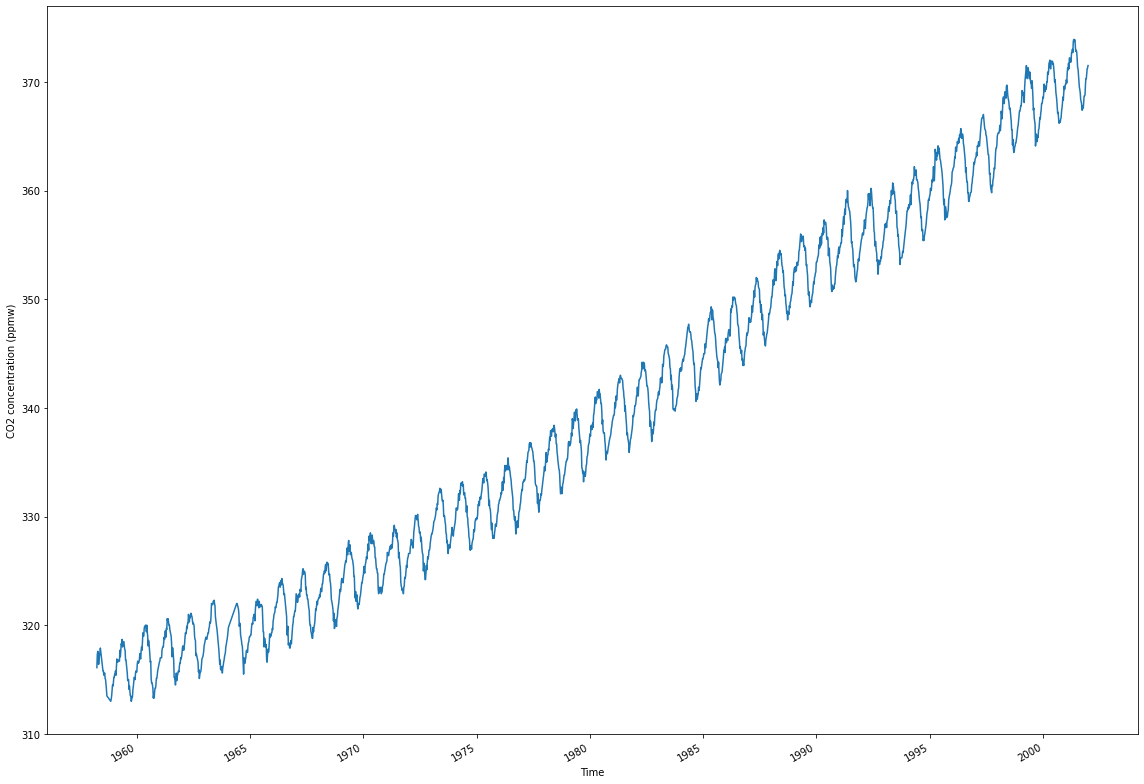

In [7]:
fig, ax = plt.subplots(figsize=(16, 11))
ax.plot(data['co2'])
ax.set_xlabel('Time')
ax.set_ylabel('CO2 concentration (ppmw)')
fig.autofmt_xdate()
plt.tight_layout()

- Há 3 diferentes maneiras para encarar esse problema:
    - Predizendo o próximo passo usando a última observação 
    - Predizendo o próximo passo usando uma sequência de observações passadas (slide window)
    - Predizendo uma sequência de passos usando uma sequência de observações passadas

#### Predizendo o próximo passo usando a última observação 

- Formatando o dataset para que a observação corrente seja uma feature para predizer a próxima observação.

In [8]:
df = data.copy()
df['y'] = df['co2'].shift(-1)
df

,co2,y
1958-03-29,316.1,317.3
1958-04-05,317.3,317.6
1958-04-12,317.6,317.5
1958-04-19,317.5,316.4
1958-04-26,316.4,316.9
...,...,...
2001-12-01,370.3,370.8
2001-12-08,370.8,371.2
2001-12-15,371.2,371.3
2001-12-22,371.3,371.5


- Dividindo dataset em treino e teste. Vamos usar os últimos anos como teste. Como as observações são semanais e um ano tem 52 semanas, então temos que atribuir as últimas 104 amostras para o teste.

In [9]:
train = df[:-104]
test = df[-104:]

test = test.drop(test.tail(1).index) # Drop last row, because we have a empty y

print(f'Shape of training set: {train.shape}')
print(f'Shape of test set: {test.shape}')

Shape of training set: (2180, 2)
Shape of test set: (103, 2)


- Definindo um baseline model para comparar com os modelos de machine learning. Para isso, vamos apenas atribuir o valor da observação corrente como o nosso y predito.

In [10]:
test = test.copy()
test['baseline_pred'] = test['co2']

test

,co2,y,baseline_pred
2000-01-08,368.5,369.0,368.5
2000-01-15,369.0,369.8,369.0
2000-01-22,369.8,369.2,369.8
2000-01-29,369.2,369.1,369.2
2000-02-05,369.1,369.6,369.1
...,...,...,...
2001-11-24,370.3,370.3,370.3
2001-12-01,370.3,370.8,370.3
2001-12-08,370.8,371.2,370.8
2001-12-15,371.2,371.3,371.2


- Aplicando Decision Tree

In [11]:
from sklearn.tree import DecisionTreeRegressor

X_train = train['co2'].values.reshape(-1,1)
y_train = train['y'].values.reshape(-1,1)
X_test = test['co2'].values.reshape(-1,1)

# Initialize the model
dt_reg = DecisionTreeRegressor(random_state=42)

# Fit the model
dt_reg.fit(X=X_train, y=y_train)

# Make predictions
dt_pred = dt_reg.predict(X_test)

# Assign predictions to a new column in test
test['dt_pred'] = dt_pred

test

,co2,y,baseline_pred,dt_pred
2000-01-08,368.5,369.0,368.5,368.650000
2000-01-15,369.0,369.8,369.0,368.500000
2000-01-22,369.8,369.2,369.8,369.400000
2000-01-29,369.2,369.1,369.2,369.100000
2000-02-05,369.1,369.6,369.1,368.800000
...,...,...,...,...
2001-11-24,370.3,370.3,370.3,370.533333
2001-12-01,370.3,370.8,370.3,370.533333
2001-12-08,370.8,371.2,370.8,370.800000
2001-12-15,371.2,371.3,371.2,371.000000


- Aplicando Gradient Boosting

In [12]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y=y_train.ravel())
gbr_pred = gbr.predict(X_test)
test['gbr_pred'] = gbr_pred

test

,co2,y,baseline_pred,dt_pred,gbr_pred
2000-01-08,368.5,369.0,368.5,368.650000,368.556464
2000-01-15,369.0,369.8,369.0,368.500000,368.774435
2000-01-22,369.8,369.2,369.8,369.400000,369.512468
2000-01-29,369.2,369.1,369.2,369.100000,369.041813
2000-02-05,369.1,369.6,369.1,368.800000,368.774435
...,...,...,...,...,...
2001-11-24,370.3,370.3,370.3,370.533333,370.535661
2001-12-01,370.3,370.8,370.3,370.533333,370.535661
2001-12-08,370.8,371.2,370.8,370.800000,370.710834
2001-12-15,371.2,371.3,371.2,371.000000,371.049344


- Definindo mean absolute percentage error (MAPE).

In [13]:
def mape(y_true, y_pred):
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

In [14]:
baseline_mape = mape(test['y'], test['baseline_pred'])
dt_mape = mape(test['y'], test['dt_pred'])
gbr_mape = mape(test['co2'], test['gbr_pred'])

print(f'Baseline: {baseline_mape}%')
print(f'Decision Tree: {dt_mape}%')
print(f'Gradient Boosting Regressor: {gbr_mape}%')

Baseline: 0.1%
Decision Tree: 0.21%
Gradient Boosting Regressor: 0.15%


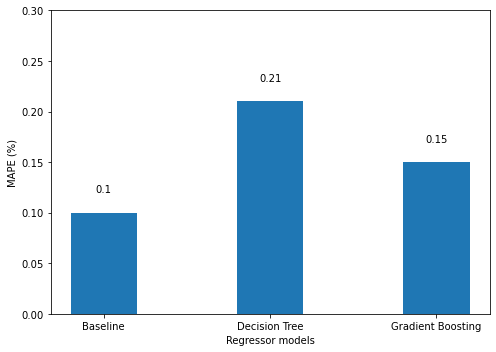

In [15]:
# Generate bar plot
fig, ax = plt.subplots(figsize=(7, 5))
x = ['Baseline', 'Decision Tree', 'Gradient Boosting']
y = [baseline_mape, dt_mape, gbr_mape]
ax.bar(x, y, width=0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 0.3)
for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.02, s=str(value), ha='center')
    
plt.tight_layout()

- Olhando o gráfico acima, nós podemos ver que o baseline teve um desempenho melhor. Faz sentido porque a concentração de CO2 não parece mudar drasticamente de uma semana para outra. O desempenho dos moledos podem sem melhores com uma sequencia de observações para predizer o próximo passo.

#### Predizendo o próximo passo usando slide window

In [16]:
data

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4
...,...
2001-12-01,370.3
2001-12-08,370.8
2001-12-15,371.2
2001-12-22,371.3


- Formatando o dataset para que tenhamos uma sequência de 5 observações para predizer a próximo estado.

In [17]:
def window_input(window_length: int, data: pd.DataFrame) -> pd.DataFrame:
    
    df = data.copy()
    
    i = 1
    while i < window_length:
        df[f'x_{i}'] = df['co2'].shift(-i)
        i = i + 1
        
    if i == window_length:
        df['y'] = df['co2'].shift(-i)
        
    # Drop rows where there is a NaN
    df = df.dropna(axis=0)
        
    return df

In [18]:
new_df = window_input(5, data)
new_df

,co2,x_1,x_2,x_3,x_4,y
1958-03-29,316.1,317.3,317.6,317.5,316.4,316.90
1958-04-05,317.3,317.6,317.5,316.4,316.9,317.20
1958-04-12,317.6,317.5,316.4,316.9,317.2,317.50
1958-04-19,317.5,316.4,316.9,317.2,317.5,317.90
1958-04-26,316.4,316.9,317.2,317.5,317.9,317.55
...,...,...,...,...,...,...
2001-10-27,368.7,368.7,368.8,369.7,370.3,370.30
2001-11-03,368.7,368.8,369.7,370.3,370.3,370.80
2001-11-10,368.8,369.7,370.3,370.3,370.8,371.20
2001-11-17,369.7,370.3,370.3,370.8,371.2,371.30


- Como baseline model vamos atribuir o valor da média das observações

In [19]:
from sklearn.model_selection import train_test_split

X = new_df[['co2', 'x_1', 'x_2', 'x_3', 'x_4']].values
y = new_df['y'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

In [20]:
baseline_pred = []

for row in X_test:
    baseline_pred.append(np.mean(row))

- Aplicando Decision Tree

In [21]:
dt_reg_5 = DecisionTreeRegressor(random_state=42)

dt_reg_5.fit(X_train, y_train)

dt_reg_5_pred = dt_reg_5.predict(X_test)

- Aplicando Gradient Boosting

In [22]:
gbr_5 = GradientBoostingRegressor(random_state=42)

gbr_5.fit(X_train, y_train.ravel())

gbr_5_pred = gbr_5.predict(X_test)

In [23]:
baseline_mape = mape(y_test, baseline_pred)
dt_5_mape = mape(y_test, dt_reg_5_pred)
gbr_5_mape = mape(y_test, gbr_5_pred)

print(f'Baseline MAPE: {baseline_mape}%')
print(f'Decision Tree MAPE: {dt_5_mape}%')
print(f'Gradient Boosting MAPE: {gbr_5_mape}%')

Baseline MAPE: 0.23%
Decision Tree MAPE: 2.14%
Gradient Boosting MAPE: 2.04%


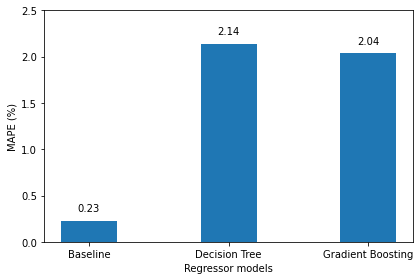

In [24]:
fig, ax = plt.subplots()

x = ['Baseline', 'Decision Tree', 'Gradient Boosting']
y = [baseline_mape, dt_5_mape, gbr_5_mape]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 2.5)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.1, s=str(value), ha='center')
    
plt.tight_layout()

- Podemos observar no gráfico acima que 5 observações não foram o suficiente para que os modelos de machine learning alcançassem um desempenho melhor do que a média das observações. Vamos então aumentar a janela de tempo.

#### Predizendo uma sequência

- Formatando o dataset para usar 26 observações para predizer o próximo estado. Em outras palavras, teremos metade do ano como entrada para predizer a próxima medade.

In [25]:
def window_input_output(input_length: int, output_length: int, data: pd.DataFrame) -> pd.DataFrame:
    
    df = data.copy()
    
    i = 1
    while i < input_length:
        df[f'x_{i}'] = df['co2'].shift(-i)
        i = i + 1
        
    j = 0
    while j < output_length:
        df[f'y_{j}'] = df['co2'].shift(-output_length-j)
        j = j + 1
        
    df = df.dropna(axis=0)
    
    return df

In [26]:
seq_df = window_input_output(26, 26, data)
seq_df.head()

,co2,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,y_16,y_17,y_18,y_19,y_20,y_21,y_22,y_23,y_24,y_25
1958-03-29,316.1,317.3,317.6,317.5,316.4,316.90,317.20,317.50,317.90,317.55,...,315.60,315.80,315.40,316.15,316.90,316.60,316.60,316.80,316.75,316.7
1958-04-05,317.3,317.6,317.5,316.4,316.9,317.20,317.50,317.90,317.55,317.20,...,315.80,315.40,316.15,316.90,316.60,316.60,316.80,316.75,316.70,316.7
1958-04-12,317.6,317.5,316.4,316.9,317.2,317.50,317.90,317.55,317.20,316.85,...,315.40,316.15,316.90,316.60,316.60,316.80,316.75,316.70,316.70,317.7
1958-04-19,317.5,316.4,316.9,317.2,317.5,317.90,317.55,317.20,316.85,316.50,...,316.15,316.90,316.60,316.60,316.80,316.75,316.70,316.70,317.70,317.1
1958-04-26,316.4,316.9,317.2,317.5,317.9,317.55,317.20,316.85,316.50,316.15,...,316.90,316.60,316.60,316.80,316.75,316.70,316.70,317.70,317.10,317.6


In [27]:
X_cols = [col for col in seq_df.columns if col.startswith('x')]

X_cols.insert(0, 'co2')

y_cols = [col for col in seq_df.columns if col.startswith('y')]

X_train = seq_df[X_cols][:-2].values
y_train = seq_df[y_cols][:-2].values

X_test = seq_df[X_cols][-2:].values
y_test = seq_df[y_cols][-2:].values

- Como baseline model, será repetido a sequencia de entrada. É uma predição tão trivial que será implementada na avaliação dos modelos.

- Aplicando Decision Tree

In [28]:
dt_seq = DecisionTreeRegressor(random_state=42)

dt_seq.fit(X_train, y_train)

dt_seq_preds = dt_seq.predict(X_test)

- Aplicando Gradient Boosting

In [29]:
from sklearn.multioutput import RegressorChain

gbr_seq = GradientBoostingRegressor(random_state=42)

chained_gbr = RegressorChain(gbr_seq)

chained_gbr.fit(X_train, y_train)

gbr_seq_preds = chained_gbr.predict(X_test)

In [30]:
mape_dt_seq = mape(dt_seq_preds.reshape(1, -1), y_test.reshape(1, -1))
mape_dt_seq

0.15

In [31]:
mape_gbr_seq = mape(gbr_seq_preds.reshape(1, -1), y_test.reshape(1, -1))
mape_gbr_seq

0.3

In [32]:
mape_baseline = mape(X_test.reshape(1, -1), y_test.reshape(1, -1))
mape_baseline

0.84

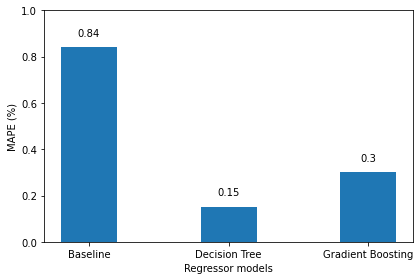

In [33]:
fig, ax = plt.subplots()

x = ['Baseline', 'Decision Tree', 'Gradient Boosting']
y = [mape_baseline, mape_dt_seq, mape_gbr_seq]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 1)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(value), ha='center')
    
plt.tight_layout()

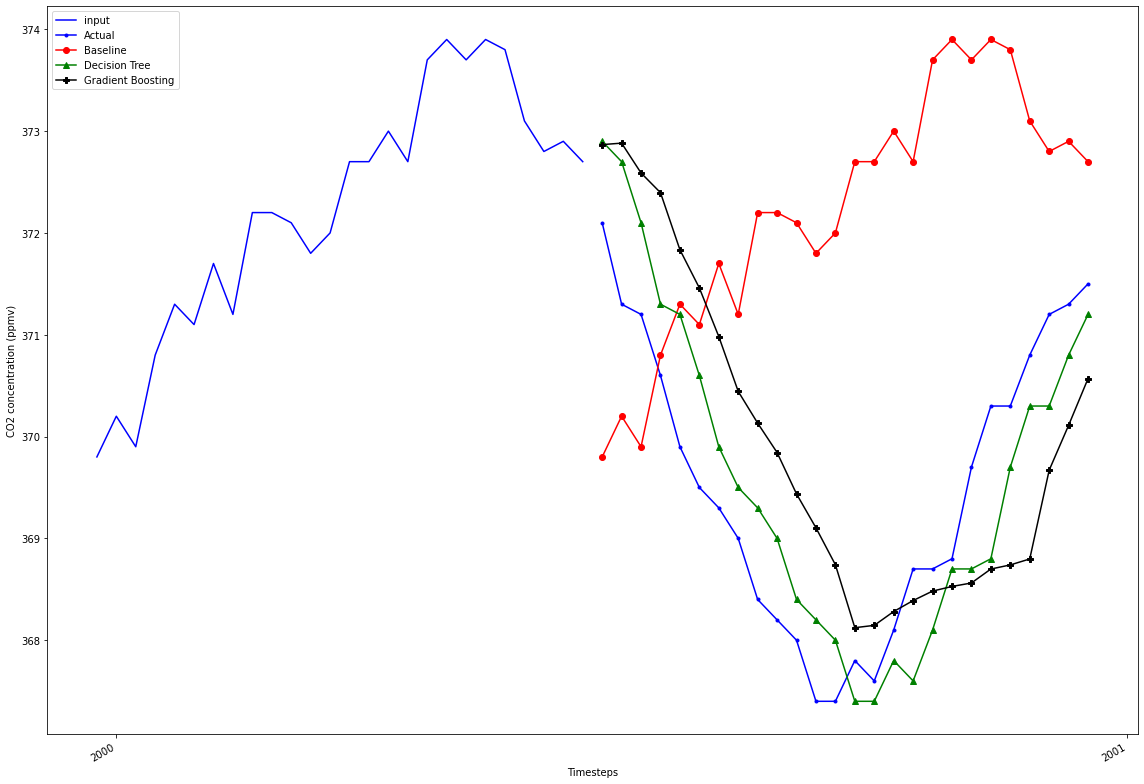

In [34]:
fig, ax = plt.subplots(figsize=(16, 11))

ax.plot(np.arange(0, 26, 1), X_test[1], 'b-', label='input')
ax.plot(np.arange(26, 52, 1), y_test[1], marker='.', color='blue', label='Actual')
ax.plot(np.arange(26, 52, 1), X_test[1], marker='o', color='red', label='Baseline')
ax.plot(np.arange(26, 52, 1), dt_seq_preds[1], marker='^', color='green', label='Decision Tree')
ax.plot(np.arange(26, 52, 1), gbr_seq_preds[1], marker='P', color='black', label='Gradient Boosting')

ax.set_xlabel('Timesteps')
ax.set_ylabel('CO2 concentration (ppmv)')

plt.xticks(np.arange(1, 104, 52), np.arange(2000, 2002, 1))
plt.legend(loc=2)

fig.autofmt_xdate()
plt.tight_layout()

- Podemos observar na imagem acima que os modelos de machine learning tiveram um desempenho melhor do que o baseline. O modelo de Decision Tree foi o que teve o melhor resultado.